In [11]:
from matplotlib import pyplot as plt
import pandas as pd

from dlvc.datasets.cifar10 import  CIFAR10Dataset
from dlvc.datasets.dataset import Subset
from torchvision.models import resnet18
from dlvc.metrics import Accuracy
import torchvision.transforms.v2 as v2
from torch import optim
import torch 
from dlvc.trainer import ImgClassificationTrainer

In [2]:
train_transform = v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
                        ])

val_transform = v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
                        ])

# Define transformations for test set
test_transform = v2.Compose([
                        v2.ToImage(),
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])

In [3]:
train_data = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py", Subset.TRAINING, train_transform)
val_data = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py",Subset.VALIDATION, val_transform)
test_data = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py", Subset.TEST, test_transform)

In [4]:
def train_model(model):
    print("Training model: ", model.__class__.__name__)
    optimizer = optim.Adam(model.parameters())
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.09)
    loss_fn = torch.nn.CrossEntropyLoss()
    train_metric = Accuracy(classes=train_data.classes)
    val_metric = Accuracy(classes=val_data.classes)
    device = torch.device("cpu")

    trainer_simple = ImgClassificationTrainer(
        model,
        optimizer,
        loss_fn,
        lr_scheduler,
        train_metric,
        val_metric,
        train_data,
        val_data,
        device,
        num_epochs = 10,
        training_save_dir="dlvc/weights/v2/" + model.__class__.__name__ + ".pt",
        batch_size=64,
        val_frequency=1
    )
    return trainer_simple

In [13]:
def test_model(model):
    print("Testing model: ", model.__class__.__name__)
    # Load test data
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
    # Load trained model
    model.load_state_dict(torch.load("dlvc/weights/v2/" + model.__class__.__name__ + ".pt"))
    model.eval()

    # Initialize metric for test set
    test_metric = Accuracy(classes=test_data.classes)

    # Define device
    device = torch.device("cpu")

    # Initialize metric for test set
    test_metric = Accuracy(classes=test_data.classes)

    # Evaluate model on test set
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            test_metric.update(output, labels)

    # Print test accuracy
    print("Test Accuracy:", test_metric.accuracy())
    print("Per-class Accuracy:", test_metric.per_class_accuracy())

    # Load existing results or create a new DataFrame
    try:
        results = pd.read_csv("results.csv")
    except FileNotFoundError:
        results = pd.DataFrame(columns=["model", "test_accuracy", "per_class_accuracy"])

    # Check if model is already in results
    if model.__class__.__name__ in results["model"].values:
        # Update results
        results.loc[results["model"] == model.__class__.__name__, "test_accuracy"] = test_metric.accuracy()
        results.loc[results["model"] == model.__class__.__name__, "per_class_accuracy"] = test_metric.per_class_accuracy()
    else:
        # Add model to results with concat
        results = pd.concat([results, pd.DataFrame([[model.__class__.__name__, test_metric.accuracy(), test_metric.per_class_accuracy()]], columns=["model", "test_accuracy", "per_class_accuracy"])], ignore_index=True)

    # Save results
    results.to_csv("results.csv", index=False)

    return model, test_metric

In [6]:
def plot_metrics(trainer):
    print("Plotting metrics for model: ", trainer.model.__class__.__name__)
    plt.style.use('ggplot')

    metrics = trainer.metrics_train
    metrics = list(zip(*metrics))
    loss = metrics[0]
    acc = metrics[1]
    class_acc = metrics[2]


    metrics_val = trainer.metrics_val
    metrics_val = list(zip(*metrics_val))
    loss_val = metrics_val[0]
    acc_val = metrics_val[1]
    class_acc_val = metrics_val[2]

    fig, ax = plt.subplots(1,3, figsize = (19,4))
    ax[0].plot(loss, label = "train")
    ax[0].plot(loss_val, label = "eval")
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(acc)
    ax[1].plot(acc_val)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[2].plot(class_acc)
    ax[2].plot(class_acc_val)
    ax[2].set_ylabel('Class Accuracy')
    ax[0].set_xlabel('Epoch')

    fig.legend()
    fig.suptitle("CNN training metrics")
    fig.savefig("img/v2/"+trainer.model.__class__.__name__ + ".png")

In [7]:
trainer = train_model(resnet18())

Training model:  ResNet


In [8]:
trainer.train()


TRAIN, EPOCH: 0 
Loss: 1.7948760986328125
Accuracy: 0.3806
Class Accuracy: 0.38053108751773834

VALIDATION, EPOCH: 0 
Loss: 1.7435438632965088
Accuracy: 0.4441
Class Accuracy: 0.44272180199623107
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 0.9596013426780701
Accuracy: 0.5407
Class Accuracy: 0.5404427289962769

VALIDATION, EPOCH: 1 
Loss: 1.3037075996398926
Accuracy: 0.5287
Class Accuracy: 0.528664517402649
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 1.0993051528930664
Accuracy: 0.597
Class Accuracy: 0.5966232806444168

VALIDATION, EPOCH: 2 
Loss: 0.9971445798873901
Accuracy: 0.5382
Class Accuracy: 0.5381337523460388
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 3 
Loss: 1.3235175609588623
Accuracy: 0.6064
Class Accuracy: 0.6061014294624328

VALIDATION, EPOCH: 3 
Loss: 1.601670742034912
Accuracy: 0.5389
C

Plotting metrics for model:  ResNet


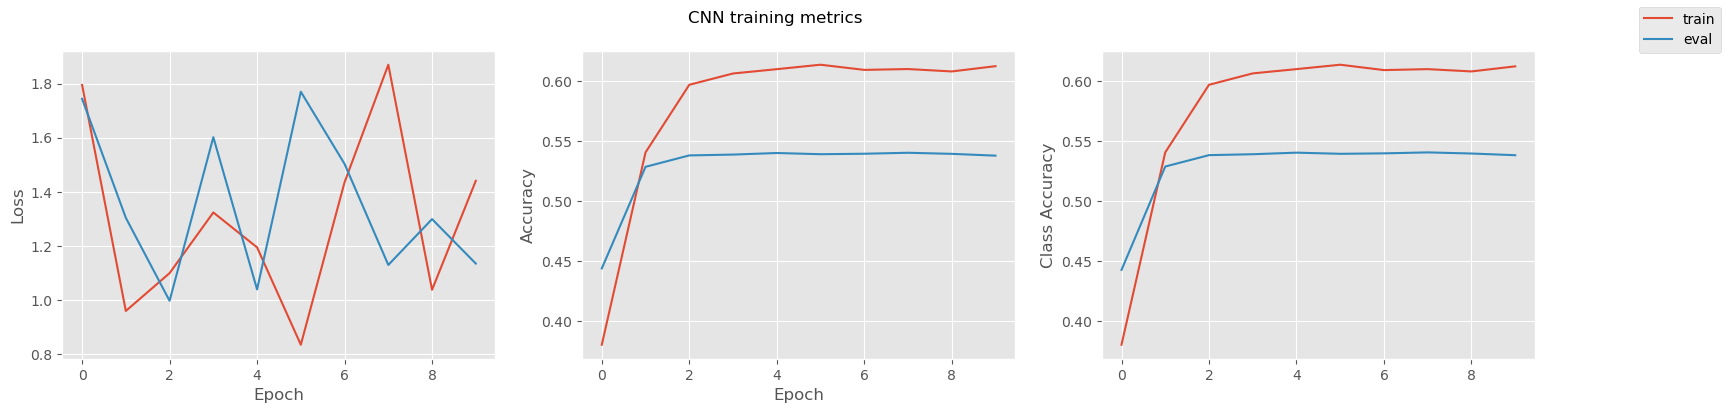

In [9]:
plot_metrics(trainer)

In [14]:
model, test_metric = test_model(resnet18())

Testing model:  ResNet
Test Accuracy: 0.5394
Per-class Accuracy: 0.5394000023603439
